<a href="https://colab.research.google.com/github/DenisSurovin/Crop-recomendation-classifier/blob/main/crop_recomend_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Датасет представляет наиболее подходящие для выращивания культуры при заданных значениях признаков. Признаки: N - содержание азота (в мг/кг), P - содержание фосфора (в мг/кг), K - содержание калия (в мг/кг), temperature - средняя температура (в градусах Цельсия), humidity - средняя влажность (в %), ph - PH среды, rainfall - количество осадков (в мм). Метки классов представляют из себя рекомендуемые культуры (рис, яблоки, апельсины и т.д.), всего 22 класса. Необходимо решить задачу классификации.

Подключение необходимых библиотек и чтение данных

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("https://raw.githubusercontent.com/DenisSurovin/Crop-recomendation-classifier/refs/heads/main/Crop_recommendation.csv")

Проверка на отсутствие ошибок при чтении данных

In [3]:
data.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


Проверка на отсутствие пустых ячеек

In [4]:
data.isna().sum()

,0
N,0
P,0
K,0
temperature,0
humidity,0
ph,0
rainfall,0
label,0


Пустых ячеек нет

Проверка сбалансированности классов

In [5]:
data.label.value_counts()

,count
label,
rice,100
maize,100
chickpea,100
kidneybeans,100
pigeonpeas,100
mothbeans,100
mungbean,100
blackgram,100
lentil,100


Классы сбалансированы

Разделение на обучающую, валидационную и тестовую выборку

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['label']), data.label, random_state=42, stratify=data.label, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, stratify=y_train, test_size=0.2)

Найдем среднее и стандартное отклонение каждого признака по обучающей выборке

In [7]:
mean_train = X_train.mean()
mean_train

,0
N,50.653409
P,53.419034
K,48.112926
temperature,25.654658
humidity,71.402800
ph,6.474062
rainfall,103.793397


In [8]:
std_train = X_train.std()
std_train

,0
N,36.937709
P,32.905399
K,50.718610
temperature,5.089184
humidity,22.387172
ph,0.781419
rainfall,55.522892


Как видно, разные признаки имеют существенно отличающиеся средние и стандартные отклонения. В дальнейшем проверим, насколько это повлияет на результат обучения моделей.

В качестве метрики будем использовать Accuracy, поскольку классы сбалансированы, и ни один класс не доминирует над другим (можно было бы предположить, что, например, выращивать яблоки выгоднее, чем выращивать апельсины, поэтому стоило бы больше штрафовать модель за ложное предсказание рекомендации выращивания апельсинов, однако при остутствии такой информации будем считать, что все культуры равнозначны).

In [9]:
from sklearn.metrics import accuracy_score

Первая модель - метод k ближайших соседей. Для определения оптимального числа соседей, используем решетчатый поиск.

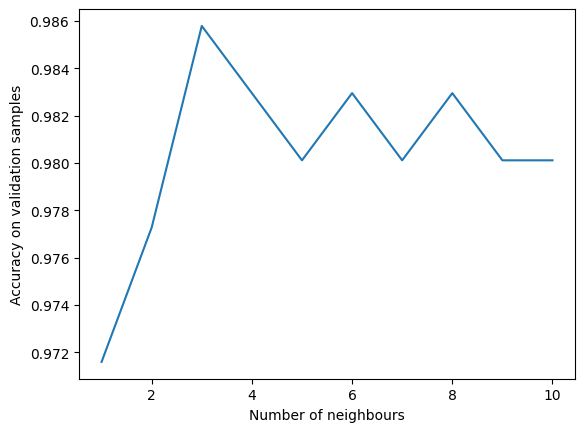

In [10]:
from sklearn.neighbors import KNeighborsClassifier

n_knn = np.arange(1, 11, 1)
accuracy_knn = np.zeros(10)

for i in range(1, 11):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(X_train, y_train)
  accuracy_knn[i - 1] = accuracy_score(knn.predict(X_val), y_val)

plt.plot(n_knn, accuracy_knn)
plt.xlabel('Number of neighbours')
plt.ylabel('Accuracy on validation samples')
plt.show()

Как видно из графика, наибольшее значение accuracy достигается при числе соседей равных 3. Окончательное обучение модели для трех соседей и значение accuracy для тестовой выборки:

In [11]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
round(accuracy_score(knn.predict(X_test), y_test), 3)

0.98

Теперь посмотрим, как изменится итоговое значение accuracy, если мы преобразуем исходные данные. Сначала используем преобразование (x - x_mean) / x_std.

In [12]:
X_test_std, X_val_std, X_train_std = (X_test - mean_train) / std_train, (X_val - mean_train) / std_train, (X_train - mean_train) / std_train

И проделаем те же самые действия.

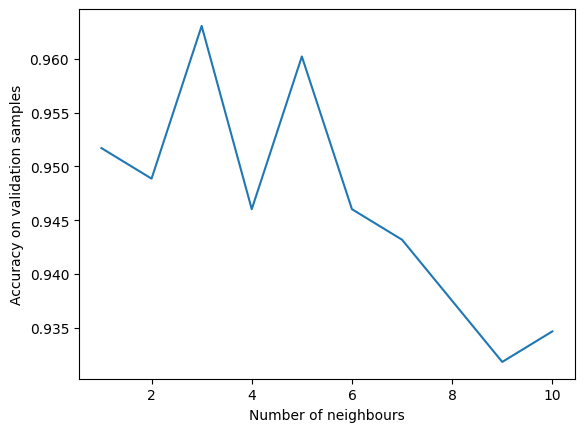

In [13]:
n_knn = np.arange(1, 11, 1)
accuracy_knn = np.zeros(10)

for i in range(1, 11):
  knn_std = KNeighborsClassifier(n_neighbors=i)
  knn_std.fit(X_train_std, y_train)
  accuracy_knn[i - 1] = accuracy_score(knn_std.predict(X_val_std), y_val)

plt.plot(n_knn, accuracy_knn)
plt.xlabel('Number of neighbours')
plt.ylabel('Accuracy on validation samples')
plt.show()

In [14]:
knn_std = KNeighborsClassifier(n_neighbors=3)
knn_std.fit(X_train_std, y_train)
round(accuracy_score(knn_std.predict(X_test_std), y_test), 3)

0.977

Итоговое значение метрики для преобразованных получилось немного меньше, чем для непреобразованных. Проделаем те же действия для преобразования (x - x_min) / (x_max - x_min).

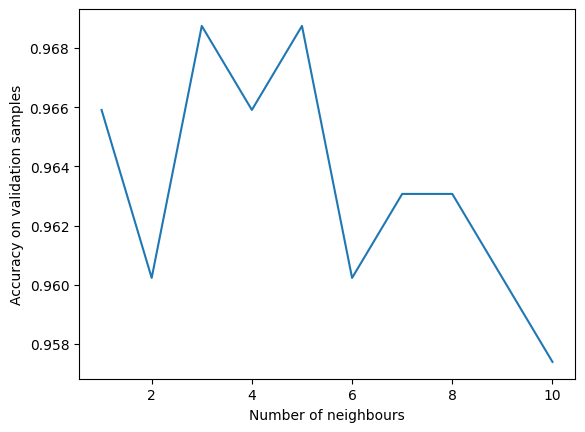

In [15]:
min_train = X_train.min()
max_train = X_train.max()

X_train_minmax, X_val_minmax, X_test_minmax = (X_train - min_train) / (max_train - min_train), (X_val - min_train) / (max_train - min_train), (X_test - min_train) / (max_train - min_train)

n_knn = np.arange(1, 11, 1)
accuracy_knn = np.zeros(10)

for i in range(1, 11):
  knn_minmax = KNeighborsClassifier(n_neighbors=i)
  knn_minmax.fit(X_train_minmax, y_train)
  accuracy_knn[i - 1] = accuracy_score(knn_minmax.predict(X_val_minmax), y_val)

plt.plot(n_knn, accuracy_knn)
plt.xlabel('Number of neighbours')
plt.ylabel('Accuracy on validation samples')
plt.show()

In [16]:
knn_minmax = KNeighborsClassifier(n_neighbors=3)
knn_minmax.fit(X_train_minmax, y_train)
round(accuracy_score(knn_minmax.predict(X_test_minmax), y_test), 3)

0.977

Значение метрики опять получилось чуть меньше, чем для непреобразованных данных. Из этого можно сделать вывод, что для этого набора данных для метода k ближайших соседей лучше использовать непреобразованные данные.

Попробуем проделать те же выкладки для линейной модели классификации. Используем метод опорных векторов.

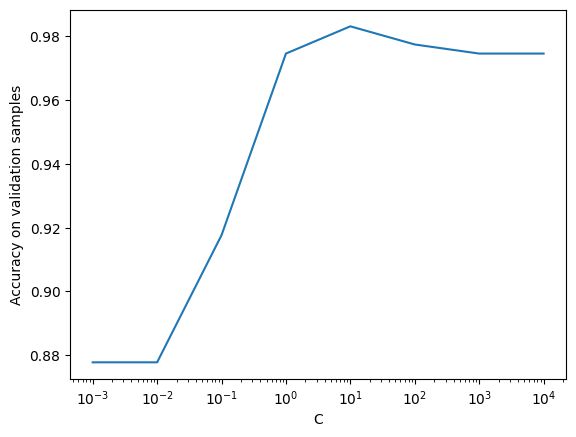

In [17]:
from sklearn.svm import SVC

C_param = np.arange(-3, 5, 1)
C_param = 10.0**C_param
accuracy_clf = np.zeros(8)

for i in range(8):
  clf = SVC(C=C_param[i])
  clf.fit(X_train, y_train)
  accuracy_clf[i] = accuracy_score(clf.predict(X_val), y_val)

plt.plot(C_param, accuracy_clf)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy on validation samples')
plt.show()

In [18]:
clf = SVC(C=10)
clf.fit(X_train, y_train)
round(accuracy_score(clf.predict(X_test), y_test), 3)

0.986

Метод опорных векторов показал более хороший результат по сравнению с методом k ближайших соседей. Теперь посмотрим на обучение на преобразованных данных.

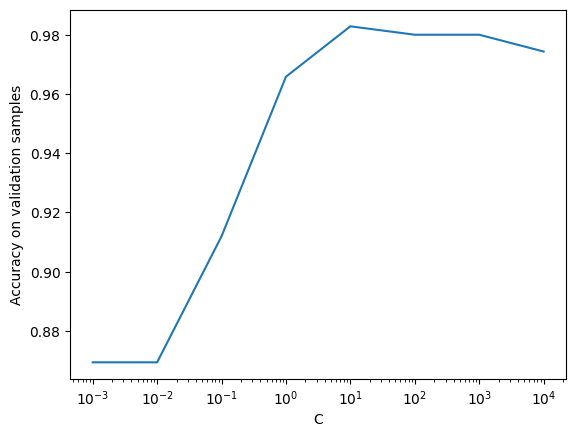

In [19]:
C_param = np.arange(-3, 5, 1)
C_param = 10.0**C_param
accuracy_clf = np.zeros(8)

for i in range(8):
  clf_std = SVC(C=C_param[i])
  clf_std.fit(X_train_std, y_train)
  accuracy_clf[i] = accuracy_score(clf_std.predict(X_val_std), y_val)

plt.plot(C_param, accuracy_clf)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy on validation samples')
plt.show()

In [20]:
clf_std = SVC(C=10)
clf_std.fit(X_train_std, y_train)
round(accuracy_score(clf_std.predict(X_test_std), y_test), 3)

0.989

Результат на преобразованных данных получился немного лучше.

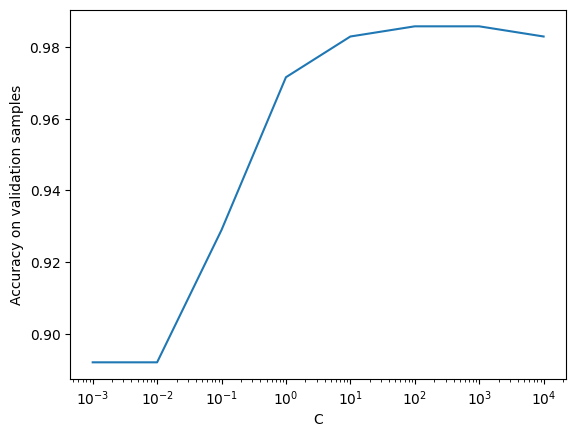

In [21]:
C_param = np.arange(-3, 5, 1)
C_param = 10.0**C_param
accuracy_clf = np.zeros(8)

for i in range(8):
  clf_minmax = SVC(C=C_param[i])
  clf_minmax.fit(X_train_minmax, y_train)
  accuracy_clf[i] = accuracy_score(clf_minmax.predict(X_val_minmax), y_val)

plt.plot(C_param, accuracy_clf)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy on validation samples')
plt.show()

Поскольку на графике видно плато от С = 10 до С = 1000, для лучшего определения парметра С проведем решетчатый поиск на более густой сетке.

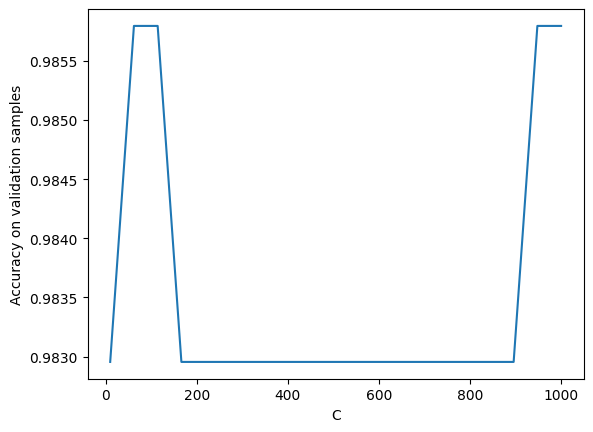

In [22]:
C_param = np.linspace(10, 1000, 20)
accuracy_clf = np.zeros(20)

for i in range(20):
  clf_minmax = SVC(C=C_param[i])
  clf_minmax.fit(X_train_minmax, y_train)
  accuracy_clf[i] = accuracy_score(clf_minmax.predict(X_val_minmax), y_val)

plt.plot(C_param, accuracy_clf)
plt.xlabel('C')
plt.ylabel('Accuracy on validation samples')
plt.show()

Определим значение параметра С, при котором метрика на валидационной выборке наибольшая.

In [23]:
int(C_param[int(np.argmax(accuracy_clf))])

62

Получаем С = 60

In [24]:
clf_minmax = SVC(C=60)
clf_minmax.fit(X_train_minmax, y_train)
round(accuracy_score(clf_minmax.predict(X_test_minmax), y_test), 3)

0.991

Получаем наибольшее значение метрики среди всех рассмотренных моделей и среди всех наборов данных (преобразованных и непреобразованных).

Проделаем те же действия для модели решающего дерева.

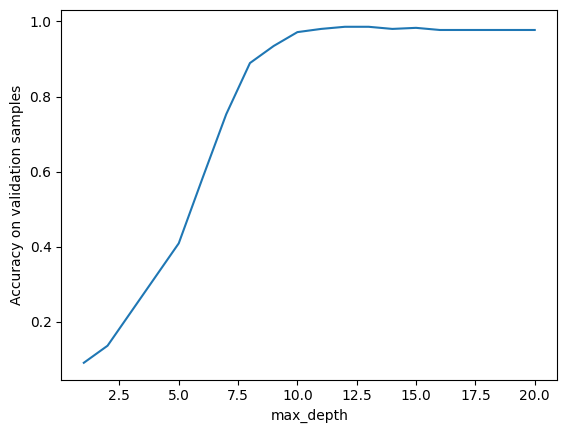

In [25]:
from sklearn.tree import DecisionTreeClassifier

max_depth_tree = np.arange(1, 21)
accuracy_dtc = np.zeros(20)

for i in max_depth_tree:
  dtc = DecisionTreeClassifier(max_depth=i, random_state=42)
  dtc.fit(X_train, y_train)
  accuracy_dtc[i - 1] = accuracy_score(dtc.predict(X_val), y_val)

plt.plot(max_depth_tree, accuracy_dtc)
plt.xlabel('max_depth')
plt.ylabel('Accuracy on validation samples')
plt.show()

In [26]:
int(max_depth_tree[np.argmax(accuracy_dtc)])

12

In [27]:
dtc = DecisionTreeClassifier(max_depth=12, random_state=42)
dtc.fit(X_train, y_train)
round(accuracy_score(dtc.predict(X_test), y_test), 3)

0.989

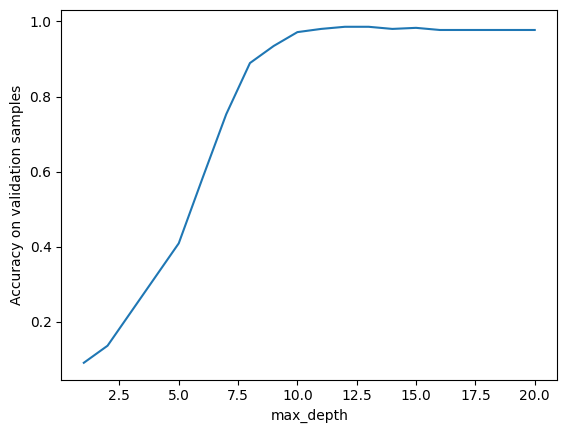

In [28]:
max_depth_tree = np.arange(1, 21)
accuracy_dtc = np.zeros(20)

for i in max_depth_tree:
  dtc_std = DecisionTreeClassifier(max_depth=i, random_state=42)
  dtc_std.fit(X_train_std, y_train)
  accuracy_dtc[i - 1] = accuracy_score(dtc_std.predict(X_val_std), y_val)

plt.plot(max_depth_tree, accuracy_dtc)
plt.xlabel('max_depth')
plt.ylabel('Accuracy on validation samples')
plt.show()

In [29]:
int(max_depth_tree[np.argmax(accuracy_dtc)])

12

In [30]:
dtc_std = DecisionTreeClassifier(max_depth=12, random_state=42)
dtc_std.fit(X_train_std, y_train)
round(accuracy_score(dtc_std.predict(X_test_std), y_test), 3)

0.989

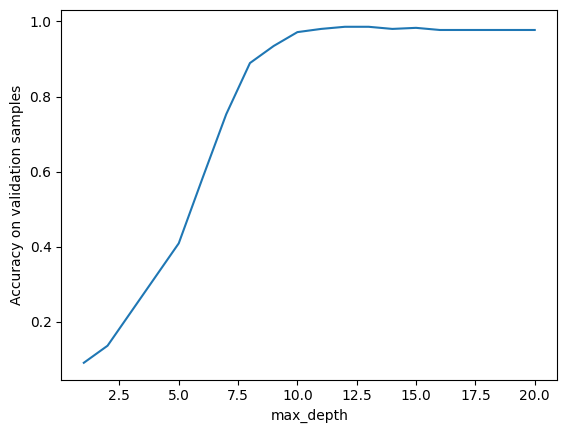

In [31]:
max_depth_tree = np.arange(1, 21)
accuracy_dtc = np.zeros(20)

for i in max_depth_tree:
  dtc_minmax = DecisionTreeClassifier(max_depth=i, random_state=42)
  dtc_minmax.fit(X_train_minmax, y_train)
  accuracy_dtc[i - 1] = accuracy_score(dtc_minmax.predict(X_val_minmax), y_val)

plt.plot(max_depth_tree, accuracy_dtc)
plt.xlabel('max_depth')
plt.ylabel('Accuracy on validation samples')
plt.show()

In [32]:
int(max_depth_tree[np.argmax(accuracy_dtc)])

12

In [33]:
dtc_minmax = DecisionTreeClassifier(max_depth=12, random_state=42)
dtc_minmax.fit(X_train_minmax, y_train)
round(accuracy_score(dtc_minmax.predict(X_test_minmax), y_test), 3)

0.989

Как видно, результаты работы модели решающего дерева не меняются для преобразованных и непреобразованных данных.

Итак, было получено, что метод опорных векторов оказался самым чувствительным к преобразованию данных, он имеет самое высокое значение accuracy для преобразования (x - x_min) / (x_max - x_min). Дерево решений и метод k ближайших соседей практически не зависят от преобразования данных.

In [38]:
result = pd.DataFrame([['SVM', round(accuracy_score(clf.predict(X_test), y_test), 3), round(accuracy_score(clf_std.predict(X_test_std), y_test), 3), round(accuracy_score(clf_minmax.predict(X_test_minmax), y_test), 3)],
                      ['kNN', round(accuracy_score(knn.predict(X_test), y_test), 3), round(accuracy_score(knn_std.predict(X_test_std), y_test), 3), round(accuracy_score(knn_minmax.predict(X_test_minmax), y_test), 3)],
                      ['Decision tree', round(accuracy_score(dtc.predict(X_test), y_test), 3), round(accuracy_score(dtc_std.predict(X_test_std), y_test), 3), round(accuracy_score(dtc_minmax.predict(X_test_minmax), y_test), 3)]],
                      columns = ['Модель', 'Непреобразованные данные', 'Преобразование (x - x_mean)/x_std', 'Преобразлование (x - x_min) / (x_max - x_min)'])
result

,Модель,Непреобразованные данные,Преобразование (x - x_mean)/x_std,Преобразлование (x - x_min) / (x_max - x_min)
0,SVM,0.986,0.989,0.991
1,kNN,0.980,0.977,0.977
2,Decision tree,0.989,0.989,0.989
